In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from zipfile import ZipFile
import keras.backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps
import time

In [2]:
# GPU-Use
# if output is empty then some installations are missing (https://www.tensorflow.org/install/pip#windows-native)
print('GPU name: ', tf.config.list_physical_devices('GPU'))
#tf.debugging.set_log_device_placement(True)

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# read images
picture_ids = []
paths = []
for dirname, _, filenames in os.walk('small_images'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        paths.append(path)

        picture_id = filename.split(".")[0]
        picture_ids.append(picture_id)

d = {"id": picture_ids, "picture_path": paths}
df = pd.DataFrame(data = d)
df

,id,picture_path
0,small_image00,small_images\small_image00.png
1,small_image01,small_images\small_image01.png
2,small_image02,small_images\small_image02.png
3,small_image03,small_images\small_image03.png
4,small_image04,small_images\small_image04.png
...,...,...
95,small_image95,small_images\small_image95.png
96,small_image96,small_images\small_image96.png
97,small_image97,small_images\small_image97.png
98,small_image98,small_images\small_image98.png


In [4]:
# read masks
picture_ids = []
mask_path = []
for dirname, _, filenames in os.walk('masks'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        mask_path.append(path)

        picture_id = filename.split(".")[0]
        picture_id = picture_id.split("_mask")[0]
        picture_ids.append(picture_id)


d = {"id": picture_ids,"mask_path": mask_path}
mask_df = pd.DataFrame(data = d)
mask_df

,id,mask_path
0,task-001-annotation-26-by-1-tag-High-rise Buil...,masks\task-001-annotation-26-by-1-tag-High-ris...
1,task-002-annotation-27-by-1-tag-High-rise Buil...,masks\task-002-annotation-27-by-1-tag-High-ris...
2,task-003-annotation-28-by-1-tag-High-rise Buil...,masks\task-003-annotation-28-by-1-tag-High-ris...
3,task-004-annotation-29-by-1-tag-High-rise Buil...,masks\task-004-annotation-29-by-1-tag-High-ris...
4,task-005-annotation-19-by-1-tag-High-rise Buil...,masks\task-005-annotation-19-by-1-tag-High-ris...
...,...,...
95,task-96-annotation-18-by-1-tag-High-rise Build...,masks\task-96-annotation-18-by-1-tag-High-rise...
96,task-97-annotation-98-by-1-tag-High-rise Build...,masks\task-97-annotation-98-by-1-tag-High-rise...
97,task-98-annotation-99-by-1-tag-High-rise Build...,masks\task-98-annotation-99-by-1-tag-High-rise...
98,task-99-annotation-100-by-1-tag-High-rise Buil...,masks\task-99-annotation-100-by-1-tag-High-ris...


In [5]:
# put images and masks into one dataframe
df["mask_path"] = mask_df.mask_path
df = df.set_index('id')
df

,picture_path,mask_path
id,,
small_image00,small_images\small_image00.png,masks\task-001-annotation-26-by-1-tag-High-ris...
small_image01,small_images\small_image01.png,masks\task-002-annotation-27-by-1-tag-High-ris...
small_image02,small_images\small_image02.png,masks\task-003-annotation-28-by-1-tag-High-ris...
small_image03,small_images\small_image03.png,masks\task-004-annotation-29-by-1-tag-High-ris...
small_image04,small_images\small_image04.png,masks\task-005-annotation-19-by-1-tag-High-ris...
...,...,...
small_image95,small_images\small_image95.png,masks\task-96-annotation-18-by-1-tag-High-rise...
small_image96,small_images\small_image96.png,masks\task-97-annotation-98-by-1-tag-High-rise...
small_image97,small_images\small_image97.png,masks\task-98-annotation-99-by-1-tag-High-rise...


In [6]:
# augmentation and pre processing
img_size = [128,128]

# adjust brightness of image
# don't alter in mask
def brightness(img, mask):
    img = tf.image.adjust_brightness(img, 0.1)
    img = tf.cast(img, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return img, mask

# adjust gamma of image
# don't alter in mask
def gamma(img, mask):
    img = tf.image.adjust_gamma(img, 0.1)
    img = tf.cast(img, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return img, mask

# adjust hue of image
# don't alter in mask
def hue(img, mask):
    img = tf.image.adjust_hue(img, -0.1)
    img = tf.cast(img, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return img, mask

def crop(img, mask):
    # crop both image and mask identically
    img = tf.image.central_crop(img, 0.7)
    # resize after cropping
    img = tf.image.resize(img, (128,128))
    mask = tf.image.central_crop(mask, 0.7)
    # resize afer cropping
    mask = tf.image.resize(mask, (128,128))
    # cast to integers as they are class numbers
    img = tf.cast(img, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return img, mask

# flip both image and mask identically
def flip_hori(img, mask):
    img = tf.image.flip_left_right(img)
    mask = tf.image.flip_left_right(mask)
    img = tf.cast(img, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return img, mask

# flip both image and mask identically
def flip_vert(img, mask):
    img = tf.image.flip_up_down(img)
    mask = tf.image.flip_up_down(mask)
    img = tf.cast(img, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return img, mask

# rotate both image and mask identically
def rotate(img, mask):
    img = tf.image.rot90(img)
    mask = tf.image.rot90(mask)
    img = tf.cast(img, tf.float32)
    mask = tf.cast(mask, tf.float32)
    return img, mask

def preprocessing(car_path, mask_path):
    car_img = tf.io.read_file(car_path)
    car_img = tf.image.decode_jpeg(car_img, channels=3)
    car_img = tf.image.resize(car_img, img_size)
    car_img = tf.cast(car_img, tf.float32) / 255.0

    mask_img = tf.io.read_file(mask_path)
    mask_img = tf.image.decode_jpeg(mask_img, channels=3)
    mask_img = tf.image.resize(mask_img, img_size)
    mask_img = mask_img[:,:,:1]
    mask_img = tf.math.sign(mask_img)


    return car_img, mask_img

def create_dataset(df, train = False):
    if not train:
        ds = tf.data.Dataset.from_tensor_slices((df["picture_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        print(len(list(ds)))
    else:
        ds = tf.data.Dataset.from_tensor_slices((df["picture_path"].values, df["mask_path"].values))
        ds = ds.map(preprocessing, tf.data.AUTOTUNE)
        print(len(list(ds)))
        a = ds.map(brightness, tf.data.AUTOTUNE)
        b = ds.map(gamma, tf.data.AUTOTUNE)
        c = ds.map(hue, tf.data.AUTOTUNE)
        d = ds.map(crop, tf.data.AUTOTUNE)
        e = ds.map(flip_hori, tf.data.AUTOTUNE)
        f = ds.map(flip_vert, tf.data.AUTOTUNE)
        g = ds.map(rotate, tf.data.AUTOTUNE)

        ds = ds.concatenate(a)
        ds = ds.concatenate(b)
        ds = ds.concatenate(c)
        ds = ds.concatenate(d)
        ds = ds.concatenate(e)
        ds = ds.concatenate(f)
        ds = ds.concatenate(g)
        print(len(list(ds)))

    return ds

In [7]:
# train test split
train_df, valid_df = train_test_split(df, random_state=42, test_size=.25)
train = create_dataset(train_df, train = True)
valid = create_dataset(valid_df)

75
600
25


In [8]:
# parameter
TRAIN_LENGTH = len(train)
# bei len(train) = 75 -> BATCH_SIZE = 16
BATCH_SIZE = 2
BUFFER_SIZE = 100

In [9]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
valid_dataset = valid.batch(BATCH_SIZE)

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

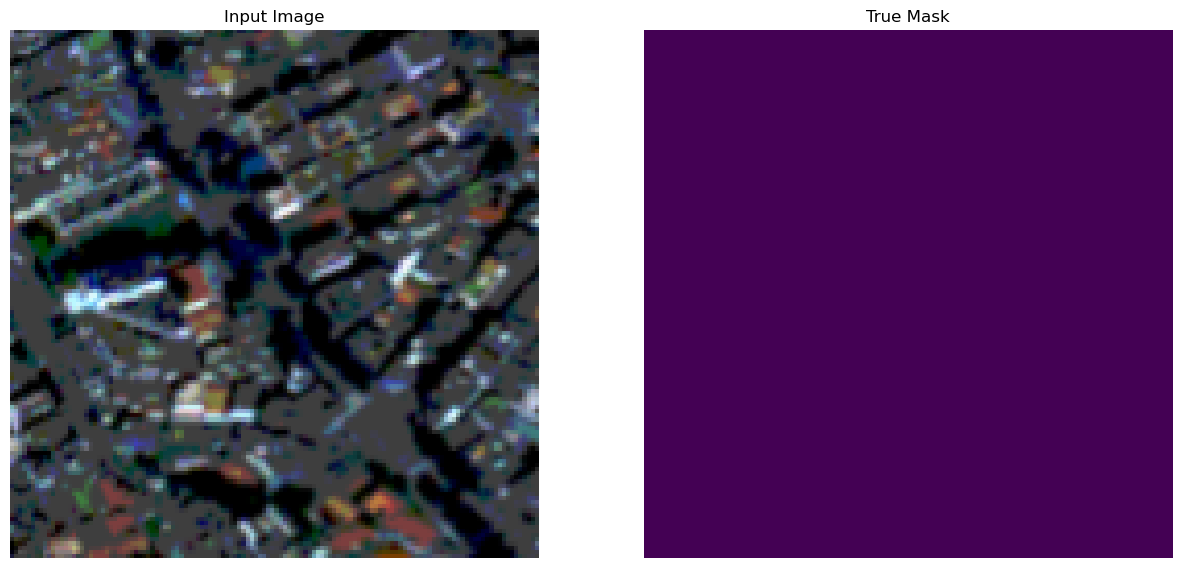

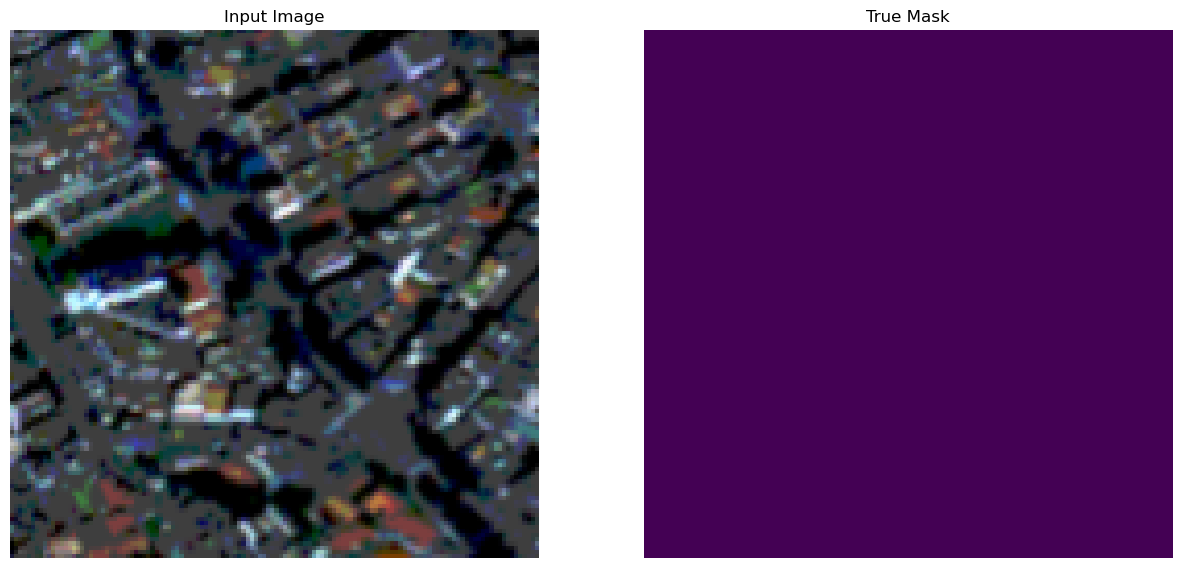

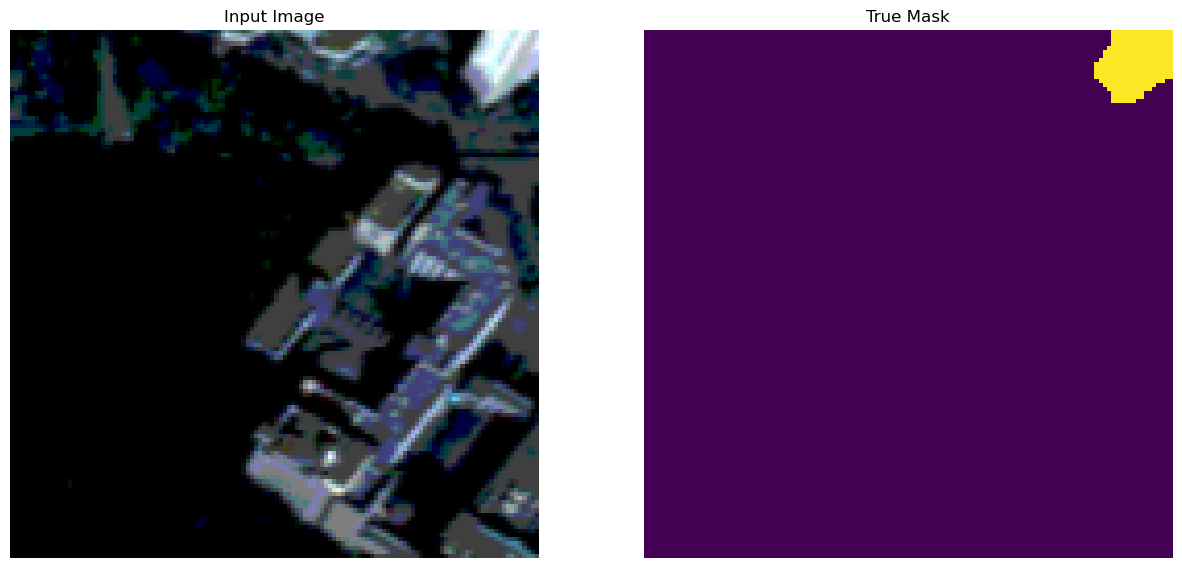

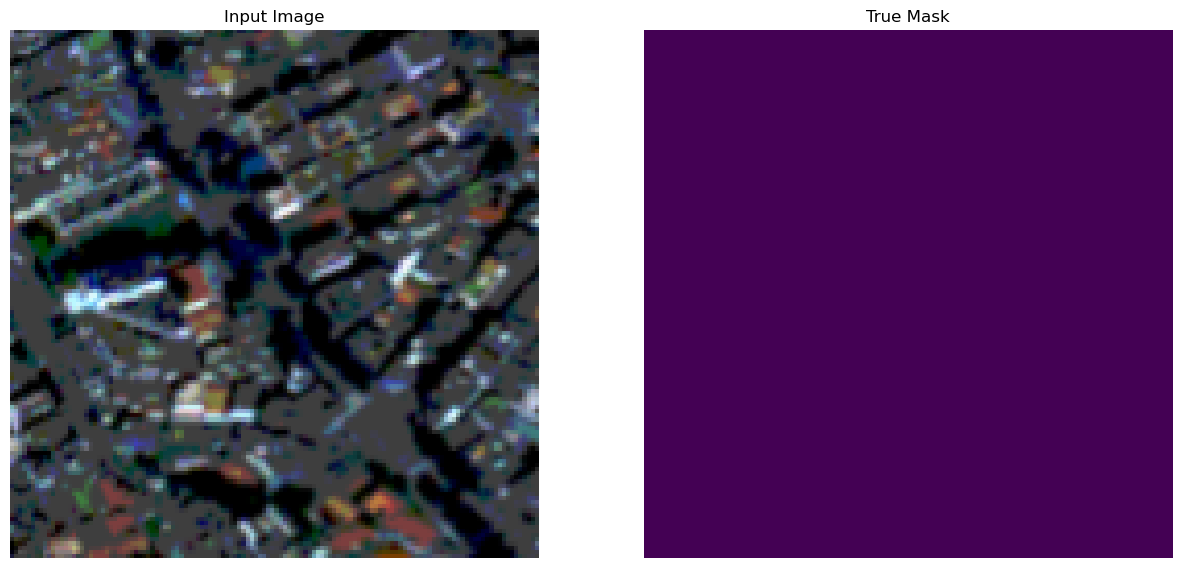

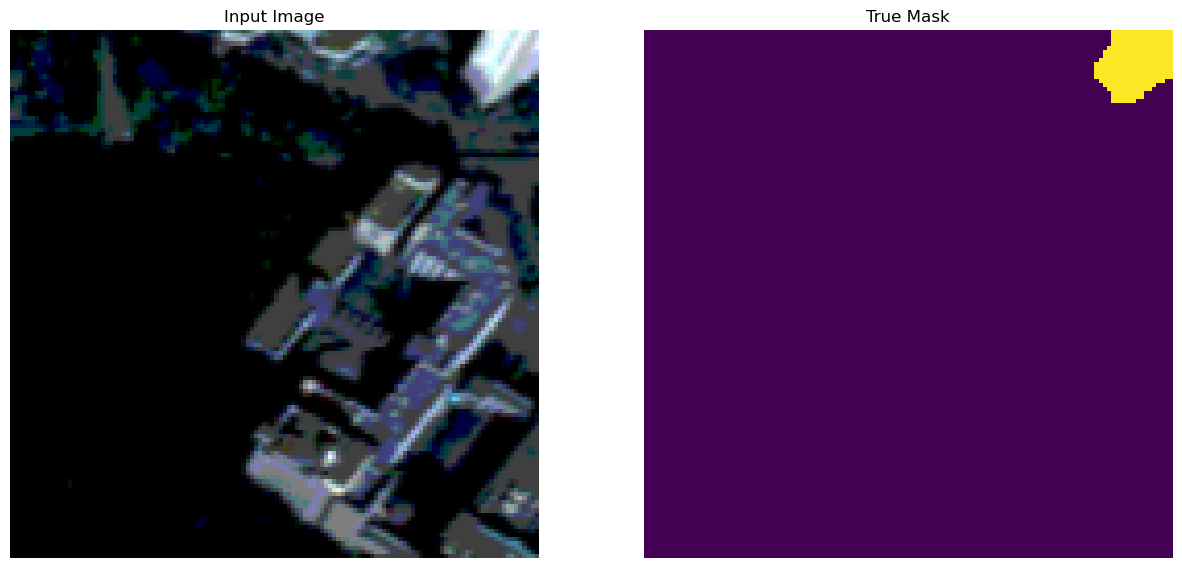

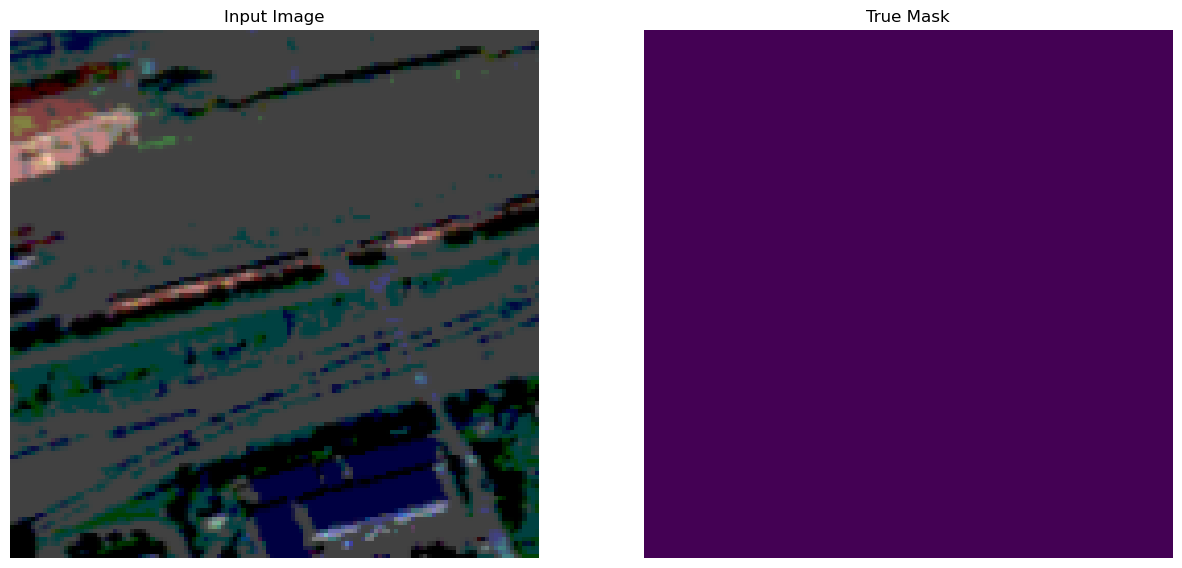

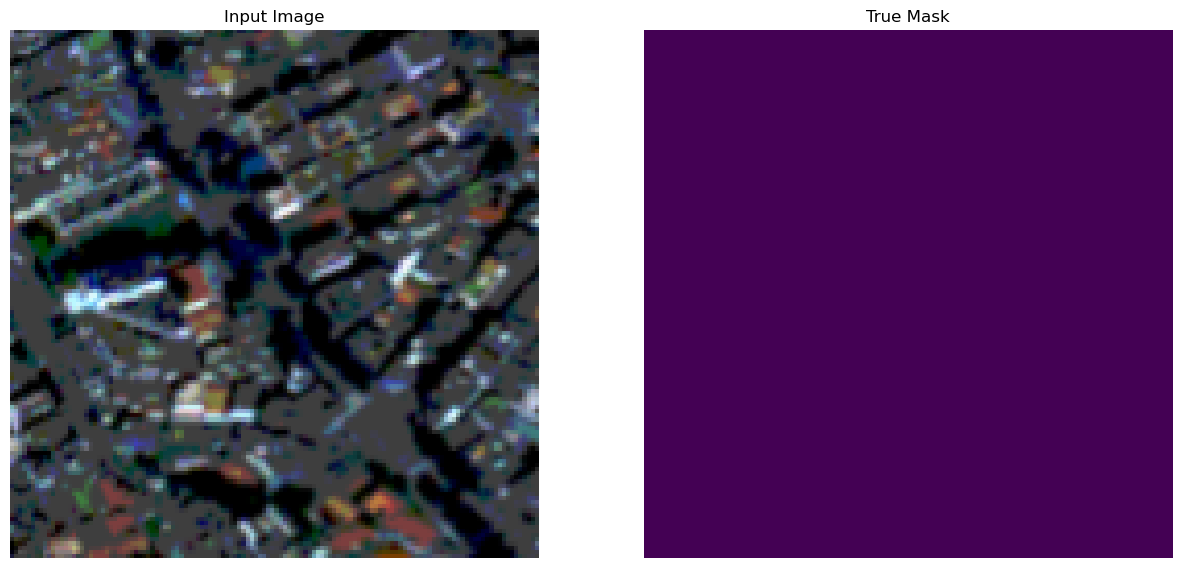

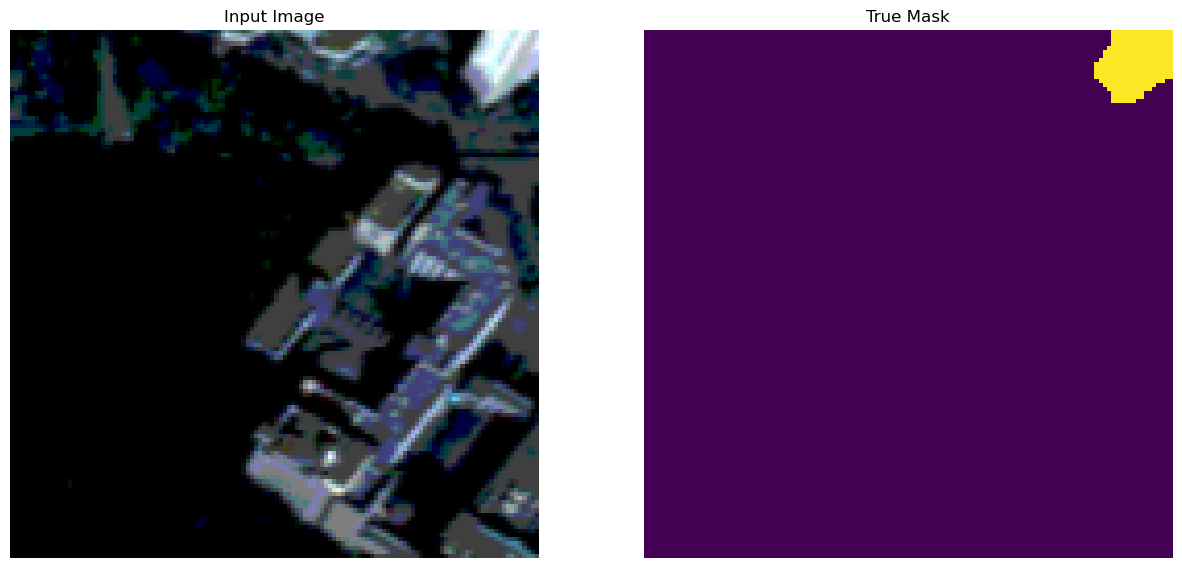

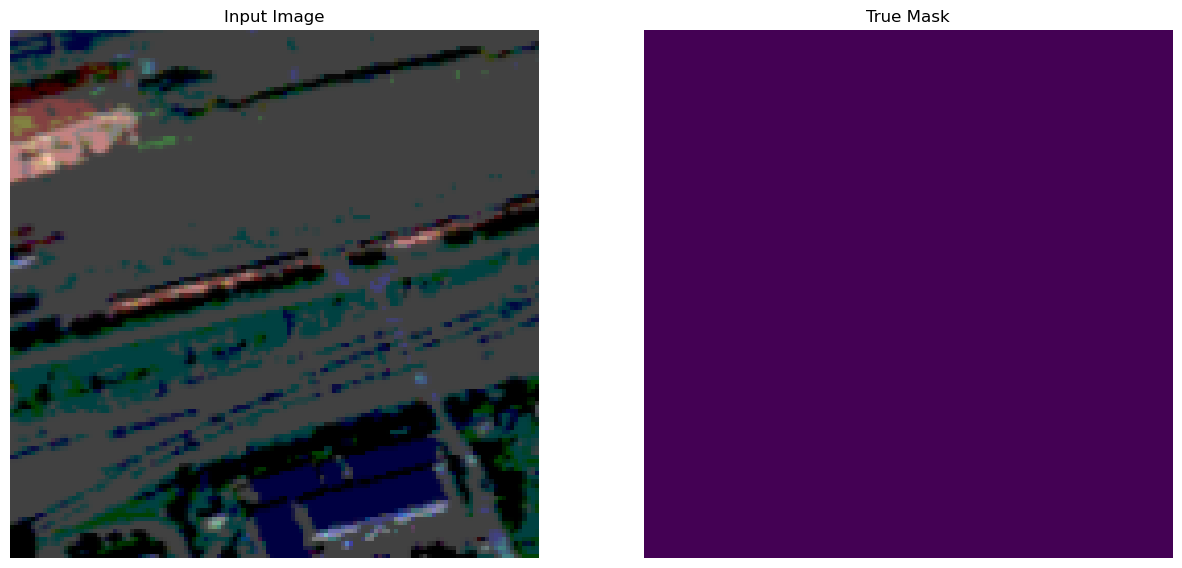

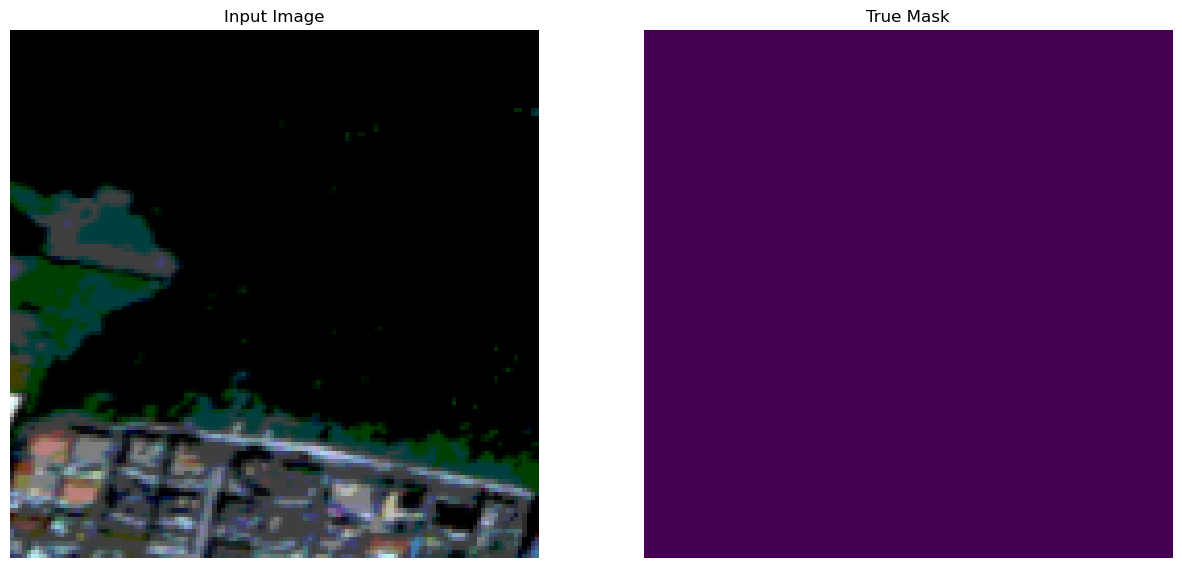

In [11]:
# view some random pictures
for i in range(5):
   for image, mask in train.take(i):
        sample_image, sample_mask = image, mask
        display([sample_image, sample_mask])

In [12]:
base_model = tf.keras.applications.DenseNet201(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
"""
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
"""
layer_names = ['conv1/relu', # size 64*64
             'pool2_relu',  # size 32*32
             'pool3_relu',  # size 16*16
             'pool4_relu',  # size 8*8
             'relu'        # size 4*4
             ]

base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)
down_stack.trainable = True

In [13]:
# needed for saving the model
class CustomLayer(tf.keras.layers.Layer):
    def __init__(self, factor):
        super().__init__()
        self.factor = factor

    def call(self, x):
        return x * self.factor

    def get_config(self):
        return {"factor": self.factor}

In [14]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

    if norm_type.lower() == 'batchnorm':
        result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
        result.add(InstanceNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

        result.add(tf.keras.layers.ReLU())

    return result

up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [15]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])

    # Downsampling through the model
    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2, activation='sigmoid',
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

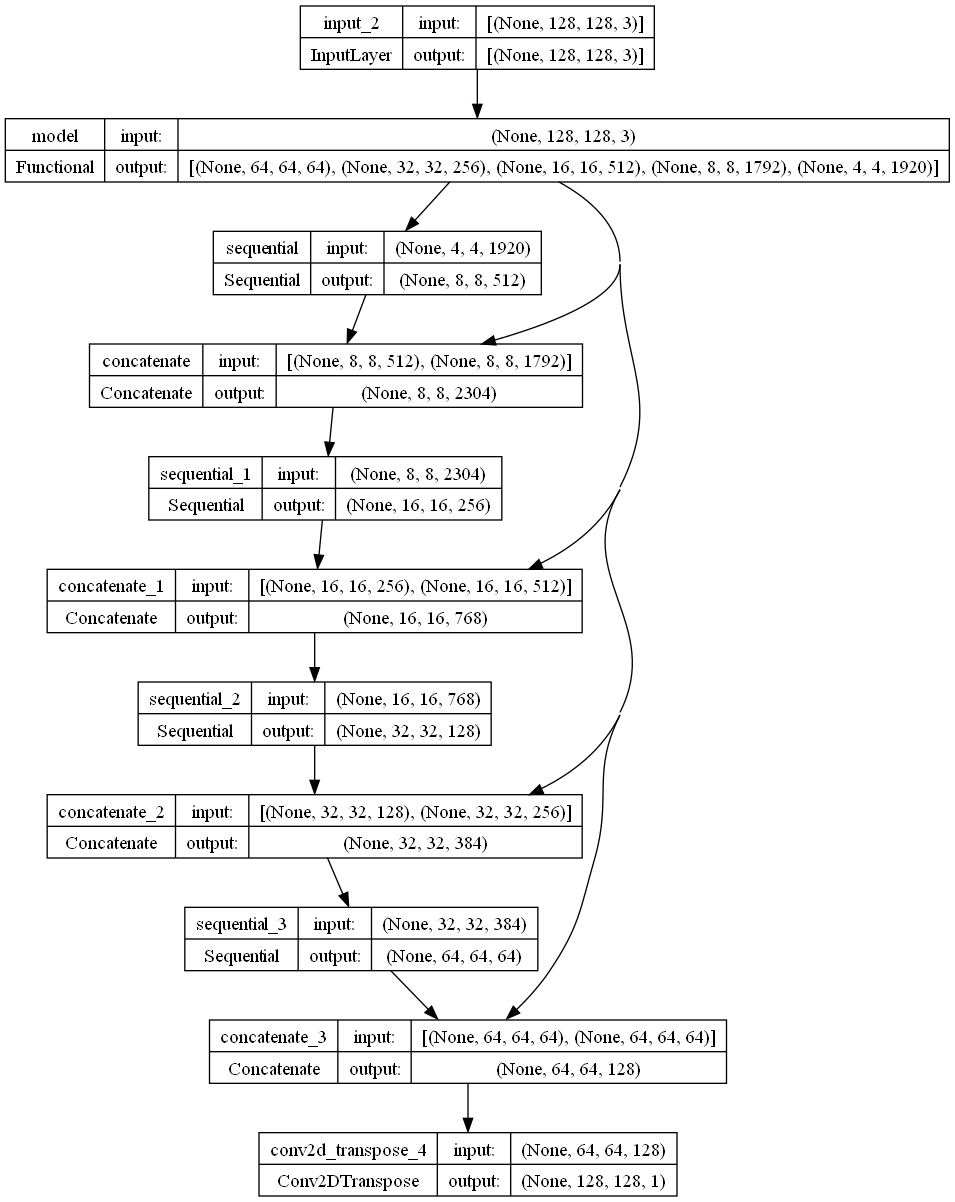

In [16]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_loss(in_gt, in_pred):
    return 1-dice_coef(in_gt, in_pred)

model = unet_model(1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[dice_coef,tf.keras.metrics.MeanIoU(num_classes=2),'binary_accuracy'])

tf.keras.utils.plot_model(model, show_shapes=True)

1/1 [==============================] - 5s 5s/step


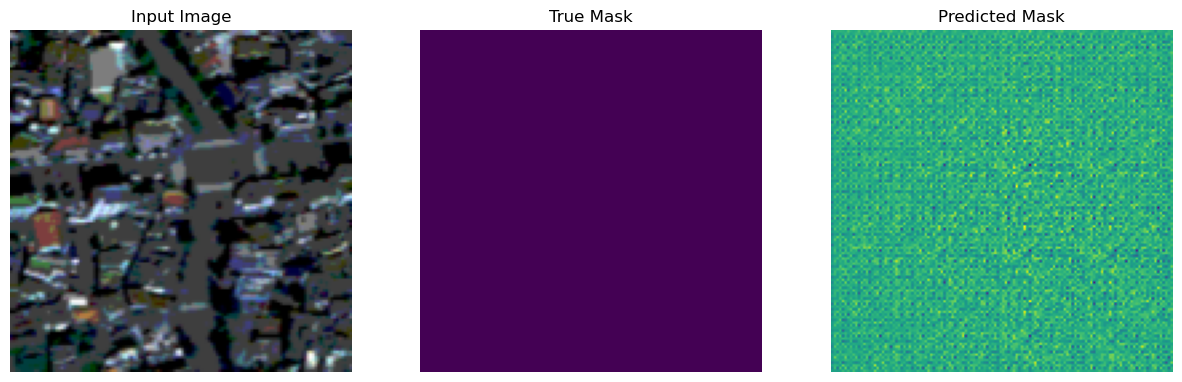

In [17]:
for images, masks in train_dataset.take(1):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
def visualize(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

def show_predictions(sample_image, sample_mask):
    pred_mask = model.predict(sample_image[tf.newaxis, ...])
    pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
    visualize([sample_image, sample_mask, pred_mask])

show_predictions(sample_image, sample_mask)

In [18]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 64)  18321984    ['input_2[0][0]']                
                                , (None, 32, 32, 25                                               
                                6),                                                               
                                 (None, 16, 16, 512                                               
                                ),                                                          

Epoch 1/10


D:\Anaconda\lib\site-packages\keras\backend.py:5673: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


300/300 [==============================] - 51s 111ms/step - loss: 0.6657 - dice_coef: 0.1500 - mean_io_u_5: 0.4511 - binary_accuracy: 0.6163 - val_loss: 0.6141 - val_dice_coef: 0.1942 - val_mean_io_u_5: 0.4428 - val_binary_accuracy: 0.7374
Epoch 2/10
1/1 [==============================] - 0s 41ms/step


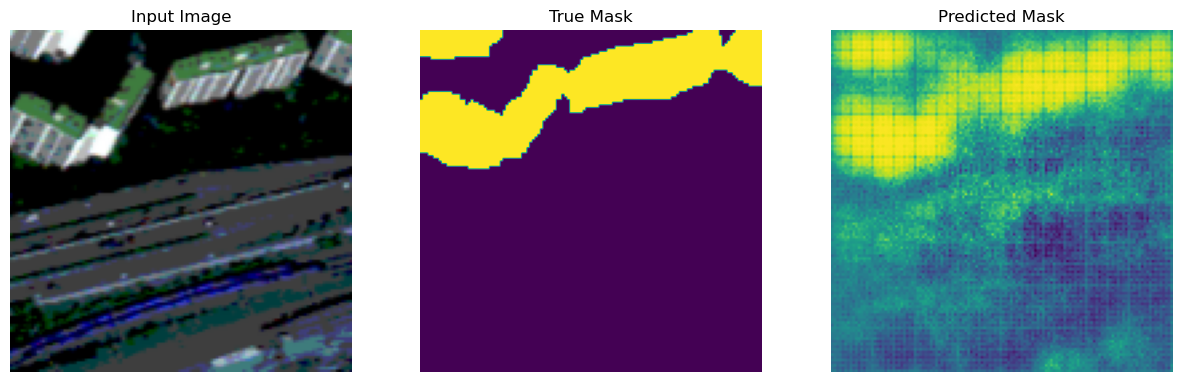

Epoch 3/10
300/300 [==============================] - 31s 102ms/step - loss: 0.5341 - dice_coef: 0.2236 - mean_io_u_5: 0.4511 - binary_accuracy: 0.7900 - val_loss: 0.4832 - val_dice_coef: 0.2675 - val_mean_io_u_5: 0.4428 - val_binary_accuracy: 0.8412
Epoch 4/10
300/300 [==============================] - 31s 102ms/step - loss: 0.4971 - dice_coef: 0.2385 - mean_io_u_5: 0.4511 - binary_accuracy: 0.8224 - val_loss: 0.4505 - val_dice_coef: 0.2782 - val_mean_io_u_5: 0.4428 - val_binary_accuracy: 0.8635
Epoch 5/10
1/1 [==============================] - 0s 41ms/step


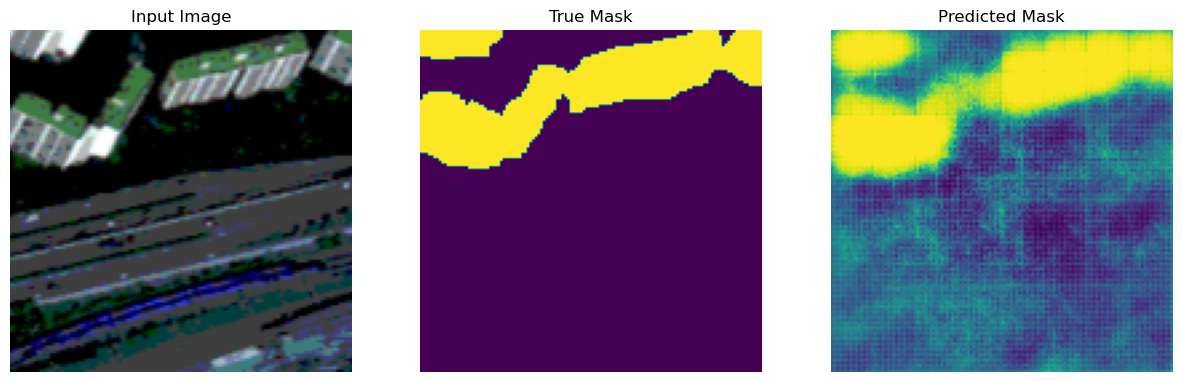

Epoch 6/10
300/300 [==============================] - 31s 102ms/step - loss: 0.4295 - dice_coef: 0.2593 - mean_io_u_5: 0.4517 - binary_accuracy: 0.8733 - val_loss: 0.3925 - val_dice_coef: 0.2978 - val_mean_io_u_5: 0.4443 - val_binary_accuracy: 0.9042
Epoch 7/10
300/300 [==============================] - 30s 98ms/step - loss: 0.4016 - dice_coef: 0.2680 - mean_io_u_5: 0.4522 - binary_accuracy: 0.8873 - val_loss: 0.3584 - val_dice_coef: 0.3114 - val_mean_io_u_5: 0.4494 - val_binary_accuracy: 0.9207
Epoch 8/10
1/1 [==============================] - 0s 40ms/step


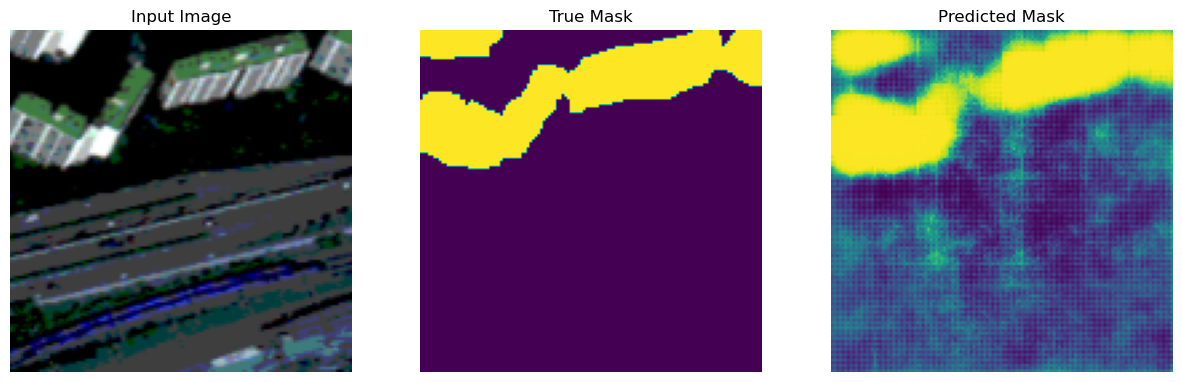

Epoch 9/10
300/300 [==============================] - 30s 100ms/step - loss: 0.3455 - dice_coef: 0.2875 - mean_io_u_5: 0.4590 - binary_accuracy: 0.9170 - val_loss: 0.3339 - val_dice_coef: 0.3208 - val_mean_io_u_5: 0.4646 - val_binary_accuracy: 0.9230
Epoch 10/10
300/300 [==============================] - 30s 100ms/step - loss: 0.3237 - dice_coef: 0.2969 - mean_io_u_5: 0.4610 - binary_accuracy: 0.9253 - val_loss: 0.3028 - val_dice_coef: 0.3366 - val_mean_io_u_5: 0.4751 - val_binary_accuracy: 0.9371


In [71]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=4,restore_best_weights=True)

class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        if (epoch + 1) % 3 == 0:
            show_predictions(sample_image, sample_mask)
EPOCHS = 10
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
#STEPS_PER_EPOCH = 30

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_data=valid_dataset,
                          callbacks=[DisplayCallback()])

In [19]:
#model.save_weights('saved_model/DenseNet201_BinaryCrossentropyT_10.weights.h5')
model.load_weights('saved_model/DenseNet201_BinaryCrossentropyT_10.weights.h5')

1/1 [==============================] - 0s 50ms/step


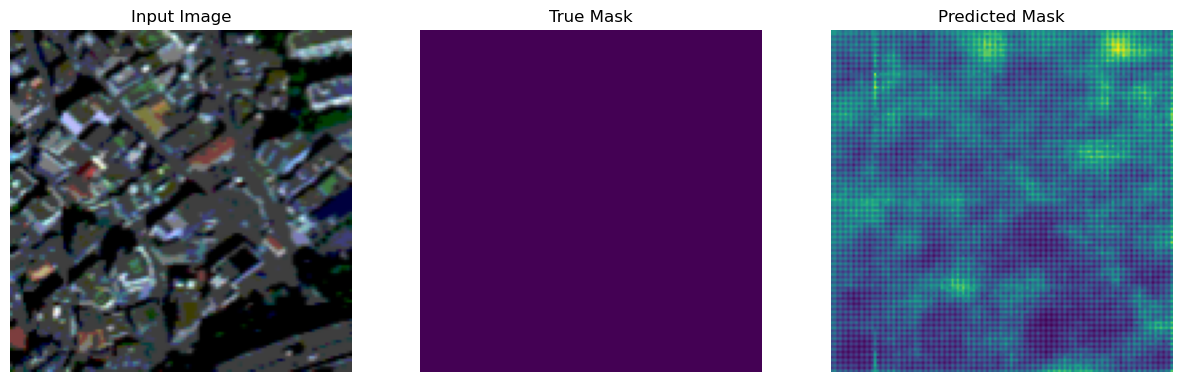

In [20]:
for images, masks in valid_dataset.take(8):
    for img, mask in zip(images, masks):
        sample_image = img
        sample_mask = mask
        break
pred_mask = model.predict(sample_image[tf.newaxis, ...])
pred_mask = pred_mask.reshape(img_size[0],img_size[1],1)
visualize([sample_image, sample_mask, pred_mask])